In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import json
import re
import math
from datetime import date
import os
import seaborn as sns
from urllib.parse import urlparse
import openai
from dotenv import load_dotenv
import time
from sklearn.manifold import TSNE
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from openai.embeddings_utils import cosine_similarity, get_embedding
from sklearn.metrics import PrecisionRecallDisplay
from ast import literal_eval
from sklearn.metrics import classification_report, precision_recall_curve, auc

import pickle



In [26]:
#This is setup so that my api key autofills on my personal computer. However, 
#running this on a different computer will require you to input your own api key

load_dotenv()  # loads the .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
openai.api_key = OPENAI_API_KEY
openai.Model.list()

EMBEDDING_MODEL = 'text-embedding-ada-002'
embedding_cache_path = "recommendations_embeddings_cache.pkl"
app_description_cache_path = "app_description_cache.pkl"
similarity_description_cache_path = "similarity_description_cache.pkl"

In [3]:
def combine_jsons_in_folder(directory):
    # List all files in directory
    files = [f for f in os.listdir(directory) if f.endswith('.json')]

    # List to store dataframes
    df_list = []

    for file in files:
        # Read each json file into a dataframe
        filepath = os.path.join(directory, file)
        df = pd.read_json(filepath)

        # Add a new column indicating the source file
        df['source_file'] = file

        # Append dataframe to the list
        df_list.append(df)

    # Concatenate all dataframes
    combined_df = pd.concat(df_list, ignore_index=True)

    return combined_df

In [4]:
def downloadData():
    # Get the directory where the script is located
    script_dir = os.getcwd()

    # Create the relative path to the PatternsData directory
    directory_path = os.path.join(script_dir, "PatternsData")
    df = combine_jsons_in_folder(directory_path)
    return df

In [5]:
def calculatetime(x):
    time = x*1000 + 978307200000
    result_ms=pd.to_datetime(str(time),unit='ms')
    return result_ms

def get_date(time):
    return str(calculatetime(time))[:10]

def get_sec(time):
    return str(calculatetime(time))[11:]
    

In [6]:
def makeTime (df):
    #create date, time, and datetime
    df['date'] = df['createdAt'].map(lambda x: get_date(x))
    df['time'] = df['createdAt'].map(lambda x: get_sec(x))
    df['datetime'] = df['createdAt'].map(lambda x: calculatetime(x))
    return df



In [7]:
def endTime(df):
    #add end time
    df['end_time'] = df['datetime'].shift(-1)
    df.dropna(subset=['end_time'], inplace=True)
    df.head()
    return df

In [8]:
def delta(df):
    df['delta'] = df['end_time'] - df['datetime']
    
    #this fills in an endtime for the last app used that day - right now it assumes 1 minute of usage, but you could also just cut the last app from the df
    df.loc[df.groupby(df['date']).tail(1).index, 'delta'] = 1

    return df

In [9]:
#URL extraction
def extract_base_url(full_url):
    parsed_url = urlparse(full_url)
    base_url = str(parsed_url.netloc)
    return base_url

def base_url(df):
    df['base_url'] = df['url'].map(lambda x: extract_base_url(x))
    return df



In [10]:
#Category JSON uploading

def readJSON(file_name):
    with open(file_name, 'r') as json_file:
        loaded_data = json.load(json_file)
        return loaded_data

def reverse_dict_handling_lists(original):
    reversed_dict = {}

    # Helper function to handle items
    def handle_item(item, key):
        if item in reversed_dict:
            reversed_dict[item].append(key)
        else:
            reversed_dict[item] = [key]

    for key, value in original.items():
        if isinstance(value, list):
            for sublist in value:
                if isinstance(sublist, list):
                    for item in sublist:
                        handle_item(item, key)
                else:
                    handle_item(sublist, key)
                    
    return reversed_dict

def addCategories(df, categories):
    df['base_url'] = df['base_url'].replace(":///", pd.NA)
    df['category'] = df.apply(
        lambda row: categories.get(row['base_url'], categories.get(row['name'], 'Other')), 
        axis=1
    )
    df['category'] = df['category'].map(lambda x: 'An app or website of this category: ' + x[0])
    return df


In [11]:
def addName(df):
    df['user'] = df['source_file'].str.split('-').str[0]
    return df

In [12]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace " -- " with " - "
    text = text.replace(" -- ", " - ")
    # Escape quotes
    text = text.replace('"', '\\"').replace("'", "\\'")
    return text

def clean_titles(df):
    df['title'] = df['title'].map(lambda x: clean_text(x))
    return df

In [13]:
def createCombined(df):
    with open(app_description_cache_path, 'rb') as file:
        data = pickle.load(file)
    df['combined'] = df.apply(lambda row: str(row['base_url']) + " -- " + str(row['title']) if row['url'] != '' else row['name'] + " -- " + data[row['name']], axis=1)
    return df


In [14]:
def cleanData(df):
    df = makeTime(df)
    df = endTime(df)
    df = delta(df)
    df = base_url(df)
    categories = reverse_dict_handling_lists(readJSON('categoriesNew.json'))
    df = addCategories(df, categories)
    df = addName(df)
    df = clean_titles(df)
    df = createCombined(df)
    return df

In [15]:
def getPatterns():
    #combines all of the functions above to download and clean data, then spits out df
    df = downloadData()
    df = cleanData(df)
    return df

In [16]:
df = getPatterns()
app_df = df[df['url'] == ""]
site_df = df[df['url'] != ""]
df.head()

,createdAt,title,name,bundleIdentifier,url,source_file,event,properties,date,time,datetime,end_time,delta,base_url,category,user,combined
0,7.018782e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:10:42.150009033,2023-03-30 14:10:42.150009033,2023-03-30 14:10:50.292375000,0 days 00:00:08.142365967,,An app or website of this category: Profession...,Monkey,Finder -- Finder: The built-in file management...
1,7.018783e+08,,Preview,com.apple.Preview,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:10:50.292375,2023-03-30 14:10:50.292375000,2023-03-30 14:10:55.191275879,0 days 00:00:04.898900879,,An app or website of this category: Profession...,Monkey,"Preview -- Preview allows users to view, edit,..."
2,7.018783e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:10:55.191275879,2023-03-30 14:10:55.191275879,2023-03-30 14:11:12.651991943,0 days 00:00:17.460716064,,An app or website of this category: Profession...,Monkey,Finder -- Finder: The built-in file management...
3,7.018783e+08,,Notion,notion.id,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:11:12.651991943,2023-03-30 14:11:12.651991943,2023-03-30 14:11:24.028187988,0 days 00:00:11.376196045,,An app or website of this category: Profession...,Monkey,Notion -- Notion is a versatile productivity a...
4,7.018783e+08,,Slack,com.tinyspeck.slackmacgap,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:11:24.028187988,2023-03-30 14:11:24.028187988,2023-03-30 14:11:26.361884033,0 days 00:00:02.333696045,,An app or website of this category: Profession...,Monkey,Slack -- Slack: A communication platform for t...


CHATGPT GENERATED APP DESCRIPTIONS BEFORE EMBEDDING

### THIS STEP IS UNNECESSARY IF THE APP DESCRIPTIONS ARE ALREADY IN THE PKL CACHE

CONSIDER ADDING ALL WEBSITES WITH VERY SHORT TITLES TO THIS LIST TO IMPROVE THEIR EMBEDDINGS

In [34]:
def generate_app_description(app, gpt_model="gpt-3.5-turbo"):

    user_message = f"Describe this app informatively in 15 words: {app}"

    category = openai.ChatCompletion.create(
        model=gpt_model,
        temperature=0.5,
        messages=[
            {"role": "system", "content": "The user needs a description of a mac app written in english. Don't include any explanations in your responses."},
            {"role": "user", "content": user_message}
        ]
    )

    return category["choices"][0]["message"]["content"]

In [35]:
appList = app_df['name'].unique()

In [36]:
def app_descriptions(appList):
    # Load the cache if it exists, and save a copy to disk
    try:
        app_cache = pd.read_pickle(app_description_cache_path)
    except FileNotFoundError:
        app_cache = {}
    
    #generate descriptions for each app
    for idx, app in enumerate(appList):

        if idx%50 == 0:
            print("Sleeping for 5s")
            time.sleep(5)
        
        if app not in app_cache.keys():
            time.sleep(0.25)
            app_cache[app] = generate_app_description(app)
            with open(app_description_cache_path, "wb") as app_description_cache_file:
                pickle.dump(app_cache, app_description_cache_file)
        print(f"Categorized: {app} -- {app_cache[app]}")
        


In [37]:
app_descriptions(appList)

Sleeping for 5s


KeyboardInterrupt: 

### NOW ONTO THE EMBEDDING

RUN THIS EVEN IF THE EMBEDDING HAS BEEN DONE ALREADY - IT WILL JUST LOAD THE OLD EMBEDDINGS IT HAS STORED

In [17]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = text, model=model)['data'][0]['embedding']

In [18]:
def batcher(df, batch_size=100):
    batched_dfs = []
    for i in range(1+len(df)//batch_size):
        new_batch = df[(i*batch_size):((i+1)*batch_size)].copy()
        batched_dfs.append(new_batch)
    return batched_dfs


In [19]:
# Load the cache if it exists, and save a copy to disk
try:
    embedding_cache = pd.read_pickle(embedding_cache_path)
except FileNotFoundError:
    embedding_cache = {}

In [20]:
def embedding_from_string(
    string: str,
    model: str = EMBEDDING_MODEL,
    embedding_cache=embedding_cache
) -> list:
    """Return embedding of given string, using a cache to avoid recomputing."""
    if (string, model) not in embedding_cache.keys():
        embedding_cache[(string, model)] = get_embedding(string, model)
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, model)]

In [21]:
def embed(batched_dfs):
    start_total_time = time.time()
    for idx, smalldf in enumerate(batched_dfs):
        start_batch_time = time.time()
        mins, secs = divmod(start_batch_time-start_total_time, 60)
        print("")
        print("------------------------------------------------------------------------------")
        print("Starting batch #" + str(idx) + " at " + str(mins) + "m " + str(round(secs)) + "s")
        
        if 'ada_embedding' not in smalldf.columns:
            # Find embeddings for batched df using the cache-aware function
            smalldf.loc[:, 'ada_embedding'] = smalldf['combined'].apply(lambda x: embedding_from_string(x))
            
        total_batch_time = time.time()-start_batch_time
        print("Batch #: " + str(idx) + " took " + str(total_batch_time) + " seconds to complete")
        print("Categorized: " + str((idx+1)*100) + " total sites.")

        if total_batch_time > 1:
            print("Waiting 1s before next batch ...")
            time.sleep(1)
        else:
            print("Last batch has already been categorized.")
    
    return batched_dfs


In [22]:
batched_df = batcher(df)

In [23]:
batched_df = embed(batched_df)
df = pd.concat(batched_df).reset_index(drop=True)


------------------------------------------------------------------------------
Starting batch #0 at 0.0m 0s
Batch #: 0 took 0.005545139312744141 seconds to complete
Categorized: 100 total sites.
Last batch has already been categorized.

------------------------------------------------------------------------------
Starting batch #1 at 0.0m 0s
Batch #: 1 took 0.0006718635559082031 seconds to complete
Categorized: 200 total sites.
Last batch has already been categorized.

------------------------------------------------------------------------------
Starting batch #2 at 0.0m 0s
Batch #: 2 took 0.0007011890411376953 seconds to complete
Categorized: 300 total sites.
Last batch has already been categorized.

------------------------------------------------------------------------------
Starting batch #3 at 0.0m 0s
Batch #: 3 took 0.0006210803985595703 seconds to complete
Categorized: 400 total sites.
Last batch has already been categorized.

------------------------------------------------

### EMBEDDING ZERO-SHOT CLASSIFICATION STRATEGY

***WARNING***
THIS WILL ONLY WORK IF THE EXISTING CATEGORIES ARE GOOD (Which they aren't)

In [24]:
def try_literal_eval(value):
    try:
        return literal_eval(value)
    except (ValueError, SyntaxError):
        return value

df["ada_embedding"] = df["ada_embedding"].apply(try_literal_eval).apply(np.array)


Final list:
1. Email
2. File Management
3. Web Browsers
4. Music Streaming
5. Video Streaming
6. Mac System and Security Applications
7. Design, Prototyping, and Visualization Tools
8. Text Messaging
9. Social Media
10. Document and Media Editing Tools
11. Google Drive
12. Calendar and Scheduling Tools
13. Online Shopping and E-commerce
14. Educational Content
15. Online Meetings and Video Conferencing
16. Team Communication and Collaboration Platforms
17. Task Management & Issue Tracking
18. Notion
19. Professional Networking
20. Microsoft Office

In [25]:
category_list = ["Email","File Management","Web Browsers","Music Streaming","Video Streaming","Mac System and Security Applications",
 "Design, Prototyping, and Visualization Tools","Social Media","Document and Media Editing Tools","Google Drive"
 ,"Calendar and Scheduling Tools","Online Shopping and E-commerce","Educational Content","Online Meetings and Video Conferencing"
 ,"Messaging and Communication Platforms","Task Management & Issue Tracking","Notion","Professional Networking","Microsoft Office"]

In [54]:
def evaluate_embeddings_approach(
    df=df,
    labels=category_list,
    model = EMBEDDING_MODEL,
):
    
    try:
        similarity_cache = pd.read_pickle(similarity_description_cache_path)
    except FileNotFoundError:
        similarity_cache = {}


    #labels = ['An app or website of this category: ' + x for x in labels]
    # Create embeddings for each label
    label_embeddings = [get_embedding(str(label), model=model) for label in labels]

    # Return the label that has the highest cosine similarity for a review
    def label_score(review_embedding, label_embeddings):
        return labels[np.argmax(cosine_similarities(review_embedding, label_embeddings))]


    def cosine_similarities(review_embedding, label_embeddings):
        return [cosine_similarity(review_embedding, label_emb) for label_emb in label_embeddings]



    df['new_category'] = df["ada_embedding"].apply(lambda x: label_score(x, label_embeddings))
    for i in range(400):
        print(f"{df['combined'][i*101]} ||| {df['new_category'][i*101]}")
    
    #report = classification_report(df['category'], preds)
    #print(report)






'   \n# TAKES A LOT OF TIME!\nPrecision-Recall curve for each label\n    for label in labels:\n        true_label = (df[\'category\'] == label).astype(int)\n        index = labels.index(label)\n        score_for_label = df["ada_embedding"].apply(lambda x: cosine_similarities(x, label_embeddings)[index])\n        precision, recall, _ = precision_recall_curve(true_label, score_for_label)\n        pr_auc = auc(recall, precision)\n\n        \n        plt.plot(recall, precision, label=f"Label {label}, AUC={pr_auc:.2f}")\n    \n    plt.xlabel("Recall")\n    plt.ylabel("Precision")\n    plt.title("Precision-Recall curve per label")\n    plt.legend(loc="best")\n    plt.show()\n'

In [55]:
evaluate_embeddings_approach(df=df)

Finder -- Finder: The built-in file management app on Mac, helping you navigate, organize, and search your files easily. ||| File Management
Slack -- Slack: A communication platform for teams, allowing seamless collaboration and efficient workflow management. ||| Messaging and Communication Platforms
mail.google.com -- Reminder - 5 mins beams user test survey - leona@usebeams.com - usebeams.com Mail ||| Email
Slack -- Slack: A communication platform for teams, allowing seamless collaboration and efficient workflow management. ||| Messaging and Communication Platforms
Slack -- Slack: A communication platform for teams, allowing seamless collaboration and efficient workflow management. ||| Messaging and Communication Platforms
linear.app -- BEA-819 Focus Break END Notification ||| Calendar and Scheduling Tools
Miro -- Miro is a collaborative online whiteboard platform that enables teams to work together visually. ||| Design, Prototyping, and Visualization Tools
mail.google.com -- Teddy @

See similar embeddings for each category

NOT NECESSARY IF YOU SUCCESSFULLY COMPLETED THE STEP ABOVE

In [194]:
def print_closest_rows(df=df, labels=category_list, model=EMBEDDING_MODEL):
    # Generate the label embeddings
    label_prefix = 'An app or website of this category: '
    labels = [label_prefix + x for x in labels]
    label_embeddings = [get_embedding(str(label), model=model) for label in labels]

    for i, label in enumerate(labels):
        # Compute cosine similarities between label's embedding and all ada_embeddings in the dataframe
        df['similarity_score'] = df["ada_embedding"].apply(lambda x: cosine_similarity(x, label_embeddings[i]))

        # Sort dataframe based on cosine similarity in descending order
        sorted_df = df.sort_values(by='similarity_score', ascending=False)

        # Get top 10 rows for this label
        top_10 = sorted_df.head(10)

        # Print out the combined column for these rows
        print(f"Top 10 closest rows for label '{labels[i]}':")
        for row in top_10['combined']:
            print(row)
        print("-" * 80)


In [200]:
#if you don't filter the dataset then the results are a bit weird use the first condition, second is if you want to see websites only
print_closest_rows(df=df[(df['combined'] != "The category of this app: ") & (df['url'] != "")])

/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_23048/3113161843.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similarity_score'] = df["ada_embedding"].apply(lambda x: cosine_similarity(x, label_embeddings[i]))


Top 10 closest rows for label 'An app or website of this category: Professional Resources & Tools':
The category of this website (title included): https://apps.apple.com/app/id775737590?mt=12&ct=d&ls=1 -- 
The category of this website (title included): https://app.clickup.com/24511094/docs/qc0kp-2061/qc0kp-27221 -- 
The category of this website (title included): https://rize.io/blog/focus-tools -- 6 Focus Tools to Help You Make the Most of Your Workdays
The category of this website (title included): https://www.vectornator.io/ -- Vectornator: Graphic Design Software
The category of this website (title included): https://dribbble.com/shots/16108018-Gamification-education-app -- Gamification education app by Trang Tran on Dribbble
The category of this website (title included): https://productlane5280.zendesk.com/agent/get-started/apps-and-integrations/connect-business-tools -- Get started – Atelier Fleckenstein – Zendesk
The category of this website (title included): https://miro.com/app

### Visualize 2-d version of the embeddings

Done already in most of the clustering functions below, so feel free to ignore

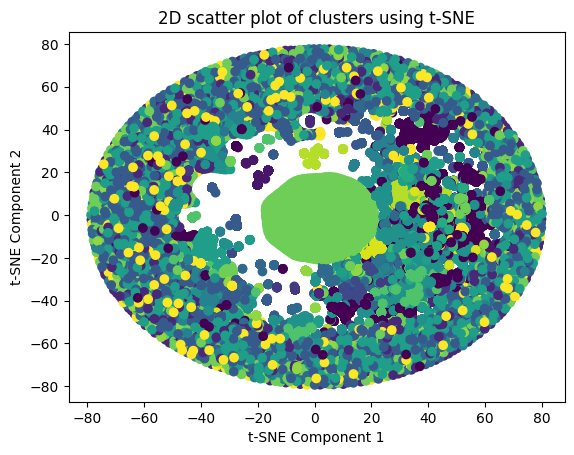

In [64]:
def visualize(full_df):
    # Convert to a list of lists of floats
    data_array = np.array(full_df['ada_embedding'].tolist())

    # Create a mapping from category to its index
    category_to_idx = {category: idx for idx, category in enumerate(category_list)}

    # Assign labels based on new_category using the mapping
    full_df['label'] = full_df['new_category'].map(category_to_idx)
    labels = full_df['label'].values

    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
    reduced_data = tsne.fit_transform(data_array)

    # Create a 2D plot
    plt.figure()

    # Scatter plot, colored by labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

    # Add labels and title
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D scatter plot of clusters using t-SNE')

    plt.show()


In [63]:
visualize(df)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### KMeans Clustering

BASIC ATTEMPT AT CLUSTERING

In [159]:

def kmeans(df):
    # Convert the Series of lists to a NumPy array
    data_array = np.array(df['ada_embedding'].tolist())

    # Perform clustering
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(data_array)

    # Get cluster labels
    labels = kmeans.labels_
    df['Cluster'] = labels

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_array)

    # Create a 2D plot
    plt.figure()

    # Scatter plot, colored by labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

    # Add cluster centers (reduced)
    centers = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x')

    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D scatter plot of clusters')

    plt.show()

    return df

    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
    reduced_data = tsne.fit_transform(data_array)

    # Create a 2D plot
    plt.figure()

    # Scatter plot, colored by labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

    # Add cluster centers (reduced using t-SNE)
    # Note: t-SNE does not provide a straightforward way to transform cluster centers, so they are not plotted in this example

    # Add labels and title
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D scatter plot of clusters using t-SNE')

    plt.show()

    


In [160]:
def separate_and_cluster(df):
    app_df = df[df['url'] == ''].copy()
    site_df = df[df['url'] != ''].copy()

    app_df = kmeans(app_df)
    site_df = kmeans(site_df)

    df = pd.concat([app_df, site_df], axis=0)
    
    return df


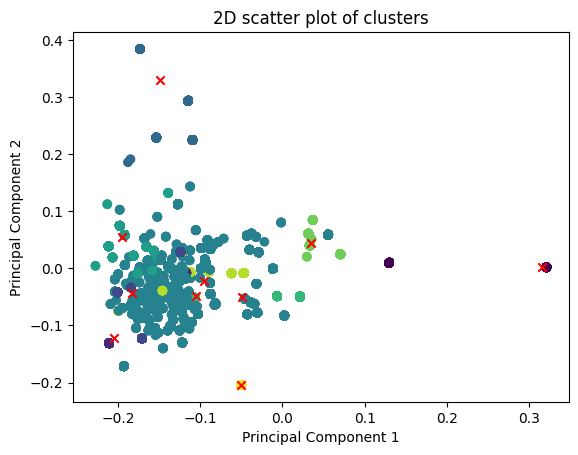

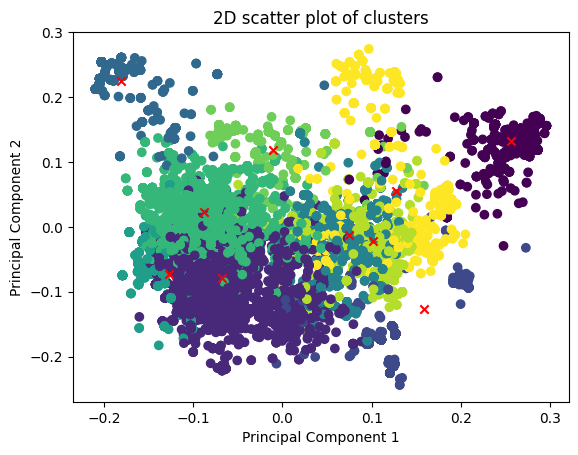

In [161]:
df = separate_and_cluster(df)



In [162]:
print(df.columns[df.columns.duplicated()])


Index([], dtype='object')


In [164]:
def print_unique_values_for_clusters(df):    
    for cluster_num in range(10):
        print(f"Cluster {cluster_num}:")
        
        # Use df_reset for operations below to avoid reindexing issues
        unique_values = df[df['Cluster'] == cluster_num]['combined'].unique()[:100]
        for idx, val in enumerate(unique_values):
            print(f"{idx}: {val}")
        print("\n" + "-"*50 + "\n")  # prints a separator for clarity

print_unique_values_for_clusters(df[df['url'] == ''])
print_unique_values_for_clusters(df[df['url'] != ''])


Cluster 0:
0: Slack -- Slack: A communication platform for teams, allowing seamless collaboration and efficient workflow management.
1: Microsoft Teams -- Microsoft Teams: A collaboration platform for chat, video meetings, file sharing, and team productivity.

--------------------------------------------------

Cluster 1:
0: Adobe Illustrator 2023 -- Adobe Illustrator 2023: Powerful graphic design software for creating precise vector graphics and stunning illustrations.
1: Arc -- Arc is a powerful and intuitive Mac app for creating stunning vector graphics and illustrations.

--------------------------------------------------

Cluster 2:
0: Finder -- Finder: The built-in file management app on Mac, helping you navigate, organize, and search your files easily.
1: Spotify -- Spotify: Stream music, create playlists, discover new artists, and enjoy personalized recommendations on your Mac.
2: Around -- Around is a Mac app that allows users to organize and manage their digital files efficie

Cluster: Type
0. Team Collaboration Platforms




Embed just base urls as well and use them for additional categorization

Avoids problem when it messes up miro and figma since the titles have "calendar" in them

Check if app clustering is working well:

In [44]:
grouped = df[df['url' == ""]].groupby('Cluster')

for cluster, group in grouped:
    unique_apps = group['combined'].unique()
    for app in unique_apps:
        print(f"{app} - {cluster}")


Slack - 0
Notion - 1
Notes - 1
Notizen - 1
Notizzettel - 1
Evernote - 1
Arc - 2
Google Chrome - 3
Brave Browser - 3
Firefox - 3
DuckDuckGo - 3
loginwindow - 4
ScreenSaverEngine - 4
Finder - 5
Finder Windows - 5
Microsoft Excel - 6
Microsoft PowerPoint - 6
Microsoft Teams - 6
Microsoft Word - 6
Preview - 7
Adobe Illustrator 2023 - 7
Figma - 7
Adobe Photoshop 2023 - 7
InDesign - 7
Vorschau - 7
Figma Beta - 7
zoom.us - 8
Google Meet - 8
ZoomAutoUpdater - 8
Patterns - 9
Miro - 9
Calendar - 9
Beams - 9
CoreServicesUIAgent - 9
System Preferences - 9
Safari - 9
TextEdit - 9
Flow - 9
Maps - 9
Captive Network Assistant - 9
UserNotificationCenter - 9
Rize - 9
Dictionary - 9
Archive Utility - 9
Loom - 9
System Information - 9
Superpowered - 9
System Settings - 9
App Store - 9
Code - 9
Terminal - 9
Calculator - 9
Installer - 9
SecurityAgent - 9
Avira Security Installer - 9
Avira Security - 9
Install Command Line Developer Tools - 9
Weather - 9
Spotify Installer - 9
Spotify - 9
ContinuityCaptureOnb

In [211]:
def kmeans_subcluster(df):
    # Convert the Series of lists to a NumPy array
    data_array = np.array(df['ada_embedding'].tolist())

    # Perform clustering
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(data_array)

    # Get cluster labels
    labels = kmeans.labels_
    df['sub_cluster'] = labels

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_array)

    # Create a 2D plot
    plt.figure()

    # Scatter plot, colored by labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

    # Add cluster centers (reduced)
    centers = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x')

    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D scatter plot of clusters')

    plt.show()
    return df

#takes too long
"""    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
    reduced_data = tsne.fit_transform(data_array)

    # Create a 2D plot
    plt.figure()

    # Scatter plot, colored by labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

    # Add cluster centers (reduced using t-SNE)
    # Note: t-SNE does not provide a straightforward way to transform cluster centers, so they are not plotted in this example

    # Add labels and title
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D scatter plot of clusters using t-SNE')

    plt.show()"""

    

"    # Reduce dimensionality using t-SNE\n    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)\n    reduced_data = tsne.fit_transform(data_array)\n\n    # Create a 2D plot\n    plt.figure()\n\n    # Scatter plot, colored by labels\n    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')\n\n    # Add cluster centers (reduced using t-SNE)\n    # Note: t-SNE does not provide a straightforward way to transform cluster centers, so they are not plotted in this example\n\n    # Add labels and title\n    plt.xlabel('t-SNE Component 1')\n    plt.ylabel('t-SNE Component 2')\n    plt.title('2D scatter plot of clusters using t-SNE')\n\n    plt.show()"

In [212]:
cluster5 = df[df['Cluster'] == 5]
cluster7 = df[df['Cluster'] == 7]
cluster8 = df[df['Cluster'] == 8]
recluster = [cluster5, cluster7, cluster8]

/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_23048/196871581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sub_cluster'] = labels


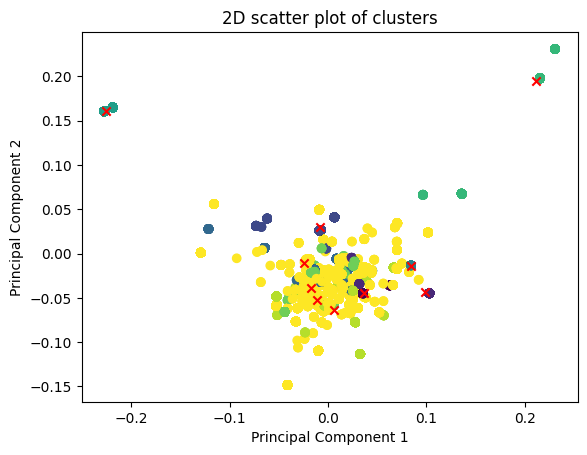

/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_23048/196871581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sub_cluster'] = labels


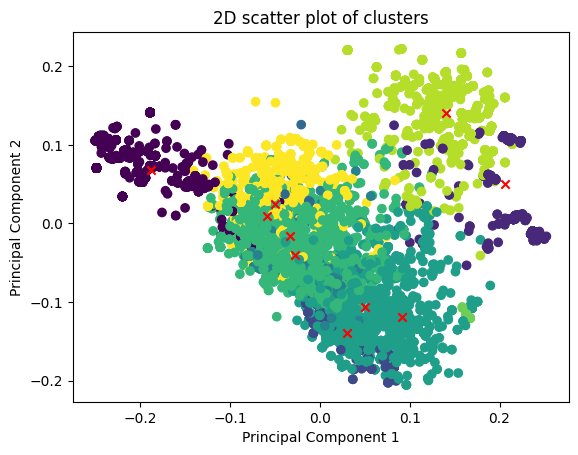

/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_23048/196871581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sub_cluster'] = labels


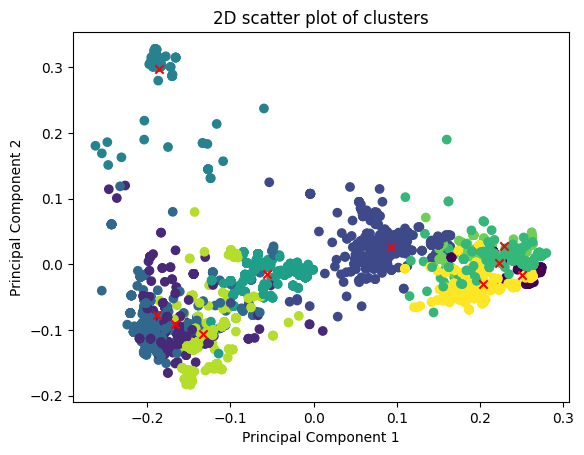

In [213]:
for cluster in recluster:
    cluster = kmeans_subcluster(cluster)

DBSCAN Clustering - more advanced

In [140]:
print(len(site_df))

12147


In [33]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [240]:
# Combine all unique 'ada_embedding' lists into a single list
unique_embeddings = app_df['ada_embedding'].explode().unique()

# Convert the combined list into a NumPy array
data_array = np.array(unique_embeddings)

# Reshape the data_array to make it 2D
data_array = data_array.reshape(-1, 1)

# Number of nearest neighbors
n_neighbors = 5

# Initialize NearestNeighbors
neigh = NearestNeighbors(n_neighbors=n_neighbors)
nbrs = neigh.fit(data_array)

# Find distances and indices of nearest neighbors
distances, indices = nbrs.kneighbors(data_array)

# Calculate the average distance to the 5th nearest neighbor
average_distances = np.mean(distances[:, n_neighbors - 1])

print(f"Average Distance to {n_neighbors}th Nearest Neighbor: {average_distances}")


distanceDec = sorted(distances[:, n_neighbors-1], reverse=True)


Average Distance to 5th Nearest Neighbor: 2.093315015675666e-06


Elbow index: 334840


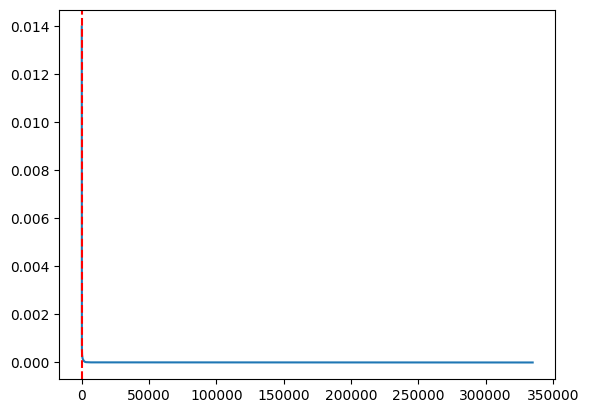

In [241]:
from kneed import KneeLocator

# You've already sorted the distances in descending order
# We need them in ascending order for the Kneedle algorithm
ascending_distances = list(reversed(distanceDec))

# Find the knee/elbow
kneedle = KneeLocator(range(len(ascending_distances)), ascending_distances, curve='convex', direction='increasing')
elbow_idx = kneedle.knee

print("Elbow index:", elbow_idx)

# Plot the distances
plt.plot(range(len(distanceDec)), distanceDec)
if elbow_idx:
    plt.axvline(x=len(distanceDec) - elbow_idx, color='red', linestyle='--') # because we reversed the list
plt.show()


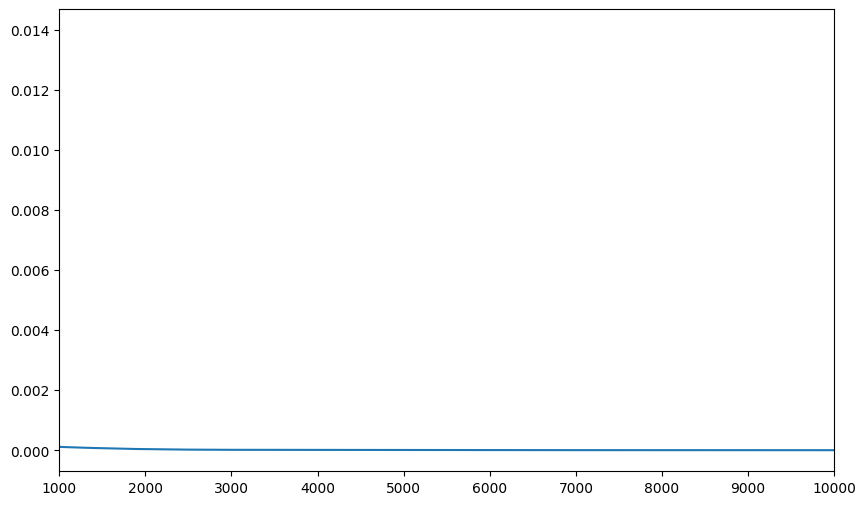

In [242]:
# Plot the distances with a zoom into the beginning
plt.figure(figsize=(10, 6))
plt.plot(range(len(distanceDec)), distanceDec)
if elbow_idx:
    plt.axvline(x=elbow_idx, color='red', linestyle='--')
plt.xlim(1000, 10000)  # adjust the range as needed to focus on the initial segment
plt.show()


In [157]:
print(distanceDec[3950])

0.041182282045001815


In [187]:
def dbscan_clustering(df):
    # Convert the Series of lists to a NumPy array
    data_array = np.array(df['ada_embedding'].tolist())

    # Step 1: Handle the dense region
    # Use DBSCAN with parameters optimized for dense regions
    eps_value = 0.05 # This is just an approximation, adjust based on the actual distance at the elbow point
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    dense_labels = dbscan.fit_predict(data_array)

    # Identify noise data points (those labeled as -1)
    sparse_data = data_array[dense_labels == -1]

    # Step 2: Handle the sparser region
    # You can either use KMeans or another instance of DBSCAN with different parameters
    kmeans = KMeans(n_clusters=10)  # Assuming you still want 10 clusters
    sparse_labels = kmeans.fit_predict(sparse_data)

    # Merge the labels back into the original dataset
    labels = np.copy(dense_labels)
    labels[dense_labels == -1] = len(np.unique(dense_labels)) + sparse_labels

    df['db_cluster'] = labels

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_array)

    # Create a 2D plot
    plt.figure()

    # Scatter plot, colored by labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D scatter plot of clusters using PCA')

    plt.show()

    return df

    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
    reduced_data = tsne.fit_transform(data_array)

    # Create a 2D plot
    plt.figure()

    # Scatter plot, colored by labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

    # Add labels and title
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D scatter plot of clusters using t-SNE')

    plt.show()

    


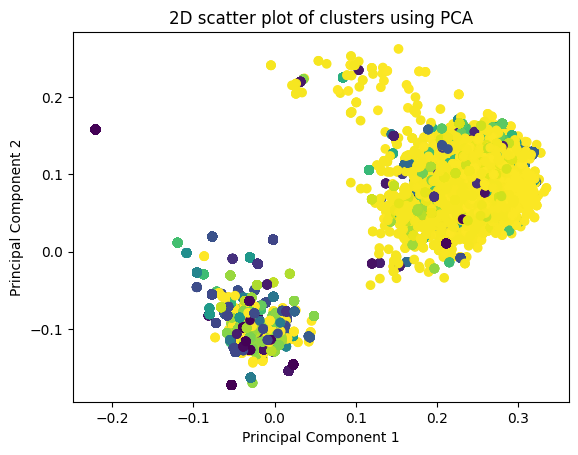

In [188]:
df = dbscan_clustering(df)

In [189]:
def print_unique_values_for_dbclusters(df):
    n = len(df['db_cluster'].unique())
    for cluster_num in range(n):
        print(f"db_cluster {cluster_num}:")
        unique_values = df[df['db_cluster'] == cluster_num]['combined'].unique()[:100]
        for val in unique_values:
            print(val)
        print("\n" + "-"*50 + "\n")  # prints a separator for clarity

print_unique_values_for_dbclusters(df)

Cluster 0:
The category of this app: Finder

--------------------------------------------------

Cluster 1:
The category of this app: Preview

--------------------------------------------------

Cluster 2:
The category of this app: Notion

--------------------------------------------------

Cluster 3:
The category of this app: Slack

--------------------------------------------------

Cluster 4:
The category of this app: Patterns

--------------------------------------------------

Cluster 5:
The category of this app: loginwindow

--------------------------------------------------

Cluster 6:
The category of this app: Miro

--------------------------------------------------

Cluster 7:
The category of this website (title included): https://www.notion.so/ -- 

--------------------------------------------------

Cluster 8:
The category of this website (title included): https://www.figma.com/ -- 

--------------------------------------------------

Cluster 9:
The category of this website 

THE FUNCTIONS BELOW THIS ARE RESPONSIBLE FOR SELECTING A SPECIFIC USER DAY AND THEN GRAPHING IT

In [67]:
def getUserDay(df, user, day):
    """
    user [str] - in the form of the user's anonymized name (i.e. "Monkey"). Make sure to use caps if necessary
    date [str] - in the form YEAR-MONTH-DAY (i.e. "2023-03-30")
    """
    user_day = df[(df.source_file == (user + "-patternsExport.json")) & (df.date == day)]

    #this fills in an endtime for the last app used that day - right now it assumes 1 minute of usage, but you could also just cut the last app from the df
    if not user_day.empty:
        user_day.iloc[-1, user_day.columns.get_loc('end_time')] = user_day.iloc[-1, user_day.columns.get_loc('datetime')] + pd.Timedelta(minutes=1)
        return user_day
    else:
        print(f"No data found for user '{user}' on day '{day}'")
    return None


In [125]:
test = getUserDay(df, "Monkey", "2023-03-30")
test.head()

,createdAt,title,name,bundleIdentifier,url,source_file,event,properties,date,time,datetime,end_time,delta,base_url,user,combined,ada_embedding
0,7.018799e+08,"usebeams.com - Calendar - Week of March 26, 2023",Google Chrome,com.google.Chrome,https://calendar.google.com/calendar/u/0/r/wee...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:38:38.991083984,2023-03-30 14:38:38.991083984,2023-03-30 14:43:19.208863037,0 days 00:04:40.217779053,https://calendar.google.com/,Monkey,https://calendar.google.com/calendar/u/0/r/wee...,"[-0.007639219518750906, -0.026348605751991272,..."
1,7.018802e+08,Re: Erik x beams - leona@usebeams.com - usebea...,Google Chrome,com.google.Chrome,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:43:37.038793945,2023-03-30 14:43:37.038793945,2023-03-30 14:43:43.726995117,0 days 00:00:06.688201172,https://mail.google.com/,Monkey,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,"[0.010895753279328346, -0.0047221616841852665,..."
2,7.018808e+08,,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Kick-Off-Messag...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:52:52.228797852,2023-03-30 14:52:52.228797852,2023-03-30 14:52:56.907240967,0 days 00:00:04.678443115,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Kick-Off-Messag...,"[-0.004148750565946102, -0.011549131013453007,..."
3,7.018808e+08,(9+) Kick-Off Message,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Kick-Off-Messag...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:53:15.003209961,2023-03-30 14:53:15.003209961,2023-03-30 14:55:31.685331055,0 days 00:02:16.682121094,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Kick-Off-Messag...,"[-0.009607917629182339, -0.013429478742182255,..."
4,7.018809e+08,,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Experiment-Desi...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:55:39.450079102,2023-03-30 14:55:39.450079102,2023-03-30 14:55:50.098559082,0 days 00:00:10.648479980,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Experiment-Desi...,"[-0.001701490138657391, -0.01200355589389801, ..."


In [13]:
def graphApps(data):
    unique_apps = data['name'].unique()
    palette = sns.color_palette('husl', len(unique_apps))
    app_colors = dict(zip(unique_apps, palette))

    fig, ax = plt.subplots()

    for index, row in data.iterrows():
        ax.hlines(y=row['name'], xmin=row['datetime'], xmax=row['end_time'], colors=app_colors[row['name']], lw=20)

    ax.set_xlim(data['datetime'].min(), data['end_time'].max())
    ax.set_xlabel('Datetime')
    ax.set_yticks(list(app_colors.keys()))
    ax.set_yticklabels(list(app_colors.keys()))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [65]:
def graphCats(data):
    unique_cats = data['new_category'].unique()
    palette = sns.color_palette('husl', len(unique_cats))
    app_colors = dict(zip(unique_cats, palette))

    fig, ax = plt.subplots()

    for index, row in data.iterrows():
        ax.hlines(y=row['new_category'], xmin=row['datetime'], xmax=row['end_time'], colors=app_colors[row['new_category']], lw=20)

    ax.set_xlim(data['datetime'].min(), data['end_time'].max())
    ax.set_xlabel('Datetime')
    ax.set_yticks(list(app_colors.keys()))
    ax.set_yticklabels(list(app_colors.keys()))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [74]:
print(df[df['user']=='Dog']['date'].unique())

['2023-04-17' '2023-04-18' '2023-04-19' '2023-04-20' '2023-05-08'
 '2023-05-09' '2023-05-10' '2023-05-11' '2023-05-12' '2023-05-13'
 '2023-05-15' '2023-05-16' '2023-05-17']


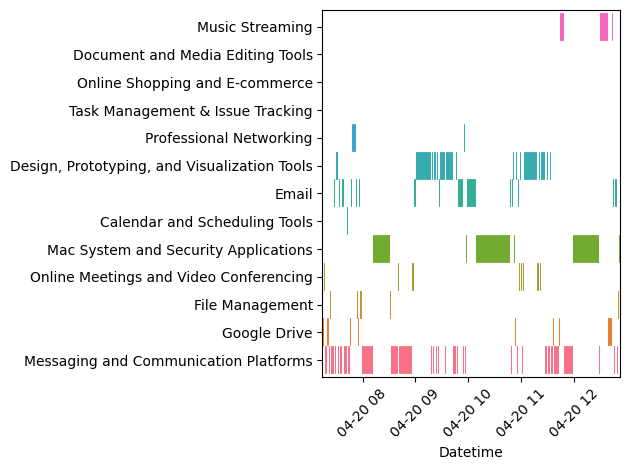

In [77]:
userday = getUserDay(df, "Fish", "2023-04-20")
graphCats(userday)

Hourly:

Productive cats

Unproductive cats

Number context switches

Live view with the meetings and blockers overlaid as well - tells you how many context switches per period time and in what categories